In [186]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

In [187]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [188]:
import bnn.functions
import bnn.loss
import bnn.network

In [189]:
dims = [32]*3 + [128]*3 + [1024]*10 + [128]*3 + [32]*10
dims = [d*2 for d in dims]
TBNN = bnn.network.TernBinNetwork(*dims, bit_shift=2, project=True)

In [190]:
samples = 1

input = bnn.functions.binarise.apply(torch.randn(samples, dims[0]))
desired = bnn.functions.binarise.apply(torch.randn(samples, dims[-1]))

In [191]:
TBNN.zero_grad()
output = TBNN(input)
loss = bnn.loss.number_incorrect(output=output, label=desired)
loss.backward()

In [192]:
vars = [] 
grad_vars = []
grads = []

for layer in TBNN.layers.values():
    grads.append(layer.W.grad.detach())
    vars.append(layer.W.var().detach())
    grad_vars.append(layer.W.grad.var().detach())

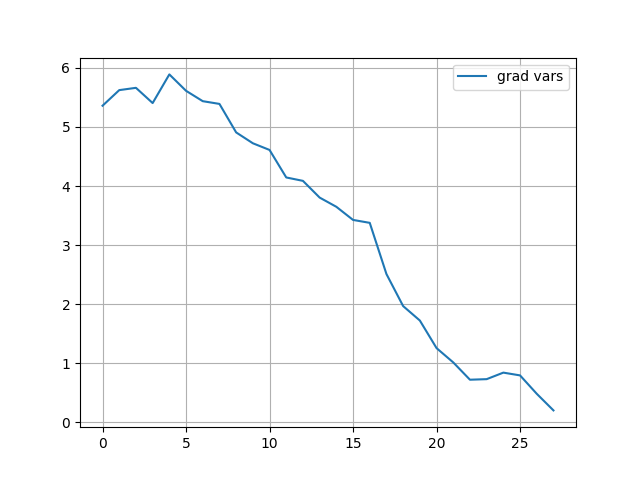

In [193]:
FIG_NAME = "vars over layers"
plt.close(FIG_NAME)

fig, ax = plt.subplots(1, 1, num=FIG_NAME)

#plt.plot(vars, label="vars")
ax.plot(grad_vars, label="grad vars")
ax.legend()
ax.grid()
plt.show()

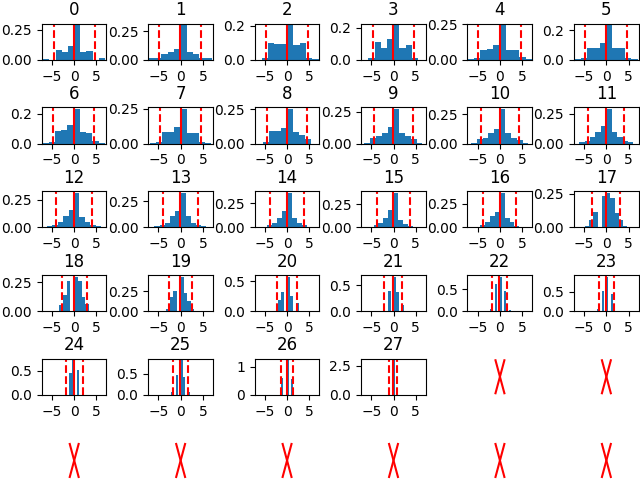

In [194]:
FIG_NAME = "grad_distribution"
plt.close(FIG_NAME)

ceil_sqrt_num_ys = np.ceil(np.sqrt(len(grad_vars))).astype(int)

fig, axs = plt.subplots(ceil_sqrt_num_ys, ceil_sqrt_num_ys, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1
for i, (ax, W) in enumerate(zip(axs, grads + [None]*len(axs))):
    if W is None:
        ax.plot(np.linspace(-1, 1), np.linspace(-1, 1), '-', color="red")
        ax.plot(np.linspace(1, -1), np.linspace(-1, 1), '-', color="red")
        ax.axis("off")
    else:
        ax.set_title(i)

        mean = W.mean().item()
        std = W.std().item()

        data = W.flatten()
        samples = 10000
        skip = int(np.ceil(len(data)/samples))
        ax.hist(data[::skip], range=(mean-3*std, mean+3*std), density=True)
        #ax.hist(Y.flatten(), density=True, color="cyan")

        min_x = min(min_x, mean-3*std)
        max_x = max(max_x, mean+3*std)

        ax.axvline(mean, color="red", ls="-")
        ax.axvline(mean+2*std, color="red", ls="--")
        ax.axvline(mean-2*std, color="red", ls="--")


for ax in axs:
    ax.set_xlim(min_x, max_x)
        

fig.tight_layout(pad=0.1)

plt.show()

In [195]:
x = torch.ones_like(input)
#x[:] = input

xs = []
xs.append(x)

with torch.no_grad():
    for layer in TBNN.layers.values():
        x = layer(x)
        xs.append(x)

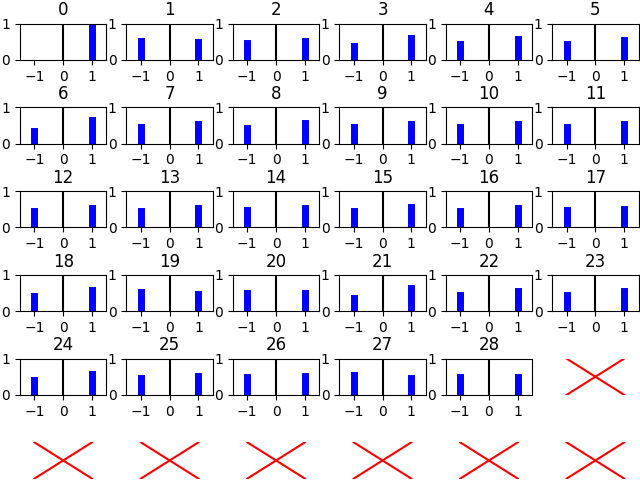

In [196]:
FIG_NAME = "distribution"
plt.close(FIG_NAME)

ceil_sqrt_num_ys = np.ceil(np.sqrt(len(xs))).astype(int)

fig, axs = plt.subplots(ceil_sqrt_num_ys, ceil_sqrt_num_ys, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1
for i, (ax, A) in enumerate(zip(axs, xs + [None]*len(axs))):
    if A is None:
        ax.plot(np.linspace(-1, 1), np.linspace(0, 1), '-', color="red")
        ax.plot(np.linspace(1, -1), np.linspace(0, 1), '-', color="red")
        ax.axis("off")
    else:
        ax.set_title(i)

        data = A.flatten()
        samples = 10000
        skip = int(np.ceil(len(data)/samples))
        #ax.hist(Y.flatten(), density=True, color="cyan")

        prop_T = (sum(data==1) / len(data)).item()
        prop_F = (sum(data==-1) / len(data)).item()
        assert 0.99 < prop_T + prop_F < 1.01

        ax.axvline(1, ymin=0, ymax=prop_T, color="blue", lw=5)
        ax.axvline(-1, ymin=0, ymax=prop_F, color="blue", lw=5)
        ax.axvline(0, color="black", ls="-")

max_x = 1.5
min_x = -max_x

for ax in axs:
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(0, 1)
        

fig.tight_layout(pad=0.1)

plt.show()